In [162]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from census import Census
from us import states

In [163]:
# Set API key
c = Census("736d0b43db328f7d01733bcff52a193181f4e05b")

In [164]:
# Obtain Census variables from the 2014 ACS at the tract level for the Commonwealth of Illinois (FIPS code: 17)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2014/acs/acs5/variables.html; https://pypi.org/project/census/
il_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.IL.fips,
                                      county_fips = "031", # Cook County
                                      tract = "*",
                                      year = 2014)

In [165]:
# Create a dataframe from the census data
il_df = pd.DataFrame(il_census)

# Show the dataframe
print(il_df.head(2))
print('Shape: ', il_df.shape)

                                          NAME  C17002_001E  C17002_002E  \
0     Census Tract 2407, Cook County, Illinois       1427.0         66.0   
1  Census Tract 8221.02, Cook County, Illinois       4580.0        182.0   

   C17002_003E  B01003_001E state county   tract  
0        440.0       1427.0    17    031  240700  
1        249.0       4752.0    17    031  822102  
Shape:  (1319, 8)


In [166]:
# Access shapefile of Illinois census tracts
il_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2014/TRACT/tl_2014_17_tract.zip")

# Reproject shapefile to UTM Zone 16N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-16n/
il_tract = il_tract.to_crs(epsg = 32616)

# Print GeoDataFrame of shapefile
print(il_tract.head(2))
print('Shape: ', il_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(il_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID NAME          NAMELSAD  MTFCC  \
0      17      161  022800  17161022800  228  Census Tract 228  G5020   
1      17      161  022900  17161022900  229  Census Tract 229  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  2097335       0  +41.4990973  -090.5473216   
1        S  1311567       0  +41.4897868  -090.5477824   

                                            geometry  
0  POLYGON ((203053.165 4599746.440, 203054.056 4...  
1  POLYGON ((203043.102 4599640.181, 203046.622 4...  
Shape:  (3123, 13)

The shapefile projection is: epsg:32616


In [167]:
# Combine state, county, and tract columns together to create a new string and assign to new column
il_df["GEOID"] = il_df["state"] + il_df["county"] + il_df["tract"]

In [168]:
# Print head of dataframe
il_df.head()

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 2407, Cook County, Illinois",1427.0,66.0,440.0,1427.0,17,031,240700,17031240700
1,"Census Tract 8221.02, Cook County, Illinois",4580.0,182.0,249.0,4752.0,17,031,822102,17031822102
2,"Census Tract 2226, Cook County, Illinois",1554.0,152.0,106.0,1554.0,17,031,222600,17031222600
3,"Census Tract 2308, Cook County, Illinois",1194.0,31.0,148.0,1195.0,17,031,230800,17031230800
4,"Census Tract 202, Cook County, Illinois",6255.0,487.0,490.0,6255.0,17,031,020200,17031020200


In [169]:
# Remove columns
il_df = il_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
il_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 2407, Cook County, Illinois",1427.0,66.0,440.0,1427.0,17031240700
1,"Census Tract 8221.02, Cook County, Illinois",4580.0,182.0,249.0,4752.0,17031822102


In [170]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(il_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(il_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [171]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
il_merge = il_tract.merge(il_df, on = "GEOID")

# Show result
print(il_merge.head(2))
print('Shape: ', il_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  NAME_x             NAMELSAD  MTFCC  \
0      17      031  030101  17031030101  301.01  Census Tract 301.01  G5020   
1      17      031  030701  17031030701  307.01  Census Tract 307.01  G5020   

  FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  122359  115695  +41.9913475  -087.6550420   
1        S   69878       0  +41.9827453  -087.6579659   

                                            geometry  \
0  POLYGON ((445305.561 4649130.618, 445324.697 4...   
1  POLYGON ((445320.511 4648168.487, 445339.650 4...   

                                       NAME_y  C17002_001E  C17002_002E  \
0  Census Tract 301.01, Cook County, Illinois       3727.0        323.0   
1  Census Tract 307.01, Cook County, Illinois       1555.0        174.0   

   C17002_003E  B01003_001E  
0        577.0       3727.0  
1        194.0       1734.0  
Shape:  (1319, 18)


In [172]:
# Create new dataframe from select columns
il_poverty_tract = il_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(il_poverty_tract.head(2))
print('Shape: ', il_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      17      031  030101  17031030101   
1      17      031  030701  17031030701   

                                            geometry  C17002_001E  \
0  POLYGON ((445305.561 4649130.618, 445324.697 4...       3727.0   
1  POLYGON ((445320.511 4648168.487, 445339.650 4...       1555.0   

   C17002_002E  C17002_003E  B01003_001E  
0        323.0        577.0       3727.0  
1        174.0        194.0       1734.0  
Shape:  (1319, 9)


In [173]:
# Get poverty rate and store values in new column
il_poverty_tract["Poverty_Rate"] = (il_poverty_tract["C17002_002E"] + il_poverty_tract["C17002_003E"]) / il_poverty_tract["B01003_001E"] * 100

# Show dataframe
il_poverty_tract.columns

/home/avasd/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'geometry', 'C17002_001E',
       'C17002_002E', 'C17002_003E', 'B01003_001E', 'Poverty_Rate'],
      dtype='object')

In [174]:
df = pd.read_csv('../../data/preprocessed_tract.csv', low_memory=False)
il_poverty_tract['GEOID'] = il_poverty_tract['GEOID'].astype(np.float64)

/home/avasd/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [175]:
df = pd.merge(df, il_poverty_tract, how='inner', left_on = 'CENSUS TRACT', right_on = 'GEOID')
df = df.drop(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'geometry', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E', 'CENSUS TRACT'], axis=1)
df = df.dropna()
df.shape

(223839, 16)

In [176]:
df.to_csv('../../data/poverty_census_data.csv', index=False)

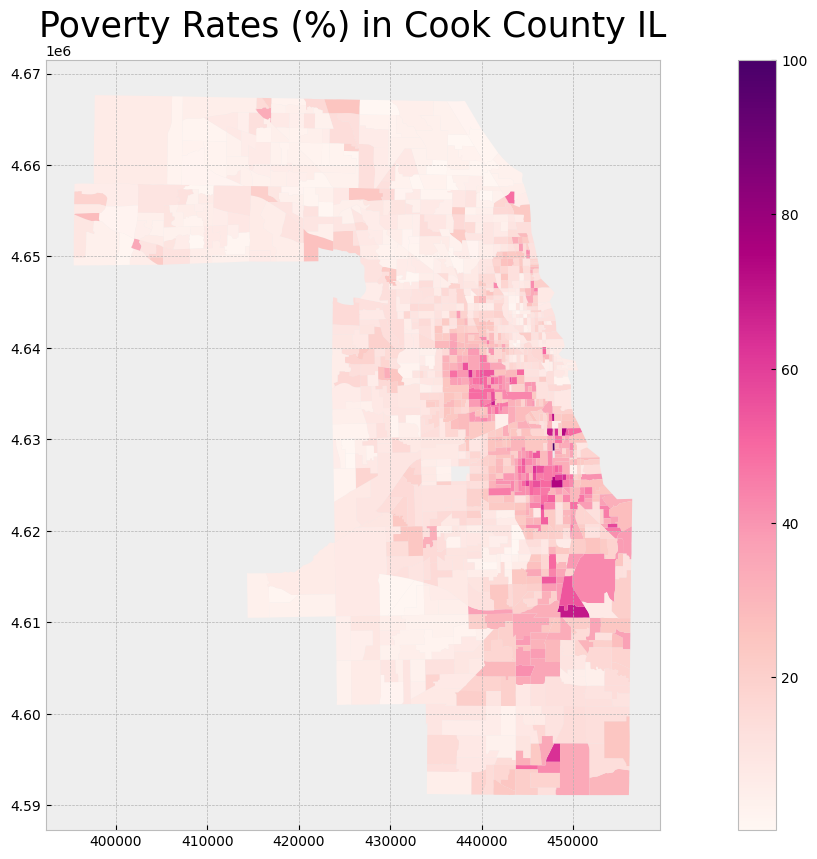

In [177]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
il_poverty_tract.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Cook County IL', fontdict = {'fontsize': '25', 'fontweight' : '3'})

plt.savefig('../images/poverty.png')